In [10]:
import pandas as pd
import biom
import qiime2
import numpy as np
import os
import skbio

import numpy as np
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection, Line3DCollection


from qiime2.plugins.emperor.actions import (plot, biplot)
from qiime2.plugins.diversity.actions import (beta_phylogenetic, pcoa, beta)
from qiime2.plugins.feature_table.actions import (rarefy, filter_samples)

from qiime2.plugins.taxa.actions import collapse

import matplotlib.pyplot as plt
from matplotlib.colors import rgb2hex

plt.rcParams['svg.fonttype'] = 'none'

import seaborn as sns

from scipy import stats
%matplotlib inline



In [1]:
import biom
import pandas as pd
from ch.ch_plots import plot_indiv_hulls_by_group
from ch.ch_plots import plot_group_hulls_over_time
from ch.ch_plots import plot_3d_hulls

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

### All we will need is a table and associated metadata

In [2]:
tab = biom.load_table('data/table.biom')
metadata = pd.read_csv('data/metadata.tsv', sep='\t')
metadata.head()

,sample_name,metab-sample-id,age_units,anonymized_name,cage_food_consumption_g,cage_location,cage_notes,cage_number,collection_timestamp,description,...,physical_specimen_location,qiita_study_id,sample_type,scientific_name,sex,taxon_id,title,weight_units,age_bin,age_match
0,11829.A41.166.21,A41_166_21,weeks,A41.166.21,46.9,In chamber,NaN,A41,6/12/18 11:00,Mouse 166 stool collection 21 of 21,...,UCSDMI,11829.0,stool,mouse gut metagenome,male,410661.0,10 week IH and IC,g,20.0,20.0
1,11829.A41.163.2,A41_163_2,weeks,A41.163.2,41.8,In chamber,NaN,A41,4/6/18 11:00,Mouse 163 stool collection 2 of 21,...,UCSDMI,11829.0,stool,mouse gut metagenome,male,410661.0,10 week IH and IC,g,12.0,10.5
2,11829.A35.142.21,A35_142_21,weeks,A35.142.21,54.5,On shelf,NaN,A35,6/12/18 12:00,Mouse 142 stool collection 21 of 21,...,UCSDMI,11829.0,stool,mouse gut metagenome,male,410661.0,10 week IH and IC,g,20.0,20.0
3,11829.A37.149.11,A37_149_11,weeks,A37.149.11,49.8,In chamber,NaN,A37,5/8/18 10:00,Mouse 149 stool collection 11 of 21,...,UCSDMI,11829.0,stool,mouse gut metagenome,male,410661.0,10 week IH and IC,g,16.0,15.0
4,11829.A41.165.2,A41_165_2,weeks,A41.165.2,41.8,In chamber,NaN,A41,4/6/18 11:00,Mouse 165 stool collection 2 of 21,...,UCSDMI,11829.0,stool,mouse gut metagenome,male,410661.0,10 week IH and IC,g,12.0,10.5


### Examine how many observations at each timepoint for each condition we have

We are interested in how IH (intermittent hypoxia) or IC (hypercapnia) alter the microbiome. Our time variable will be given by "age_match" and our group variable will be IH vs. IC vs. Air (control) which in the metadata is called "exposure_type"

In [3]:
pd.DataFrame(metadata[['age_match', 'exposure_type']].value_counts()).sort_values(by='age_match')

count
age_match exposure_type       
10.0      IC                16
          Air               15
          IH                15
10.5      IC                16
          IH                16
          Air               15
15.0      IC                16
          IH                16
          Air               15
20.0      IC                16
          IH                16
          Air               13

### Define group, subject, and time columns

In [4]:
groupc = 'exposure_type'
subjc = 'host_subject_id'
timec = 'age_match'

### Visualize each time point in 3d
Use an appropriate distance metric to generate an ordination. If you are unfamiliar with this step please consult the RPCA tutorial on the gemelli github page, which gives a more detailed explanation of how the RPCA distance metric works and how to use it. Your downstream results will be heavily impacted based on which distance metric you choose to use.

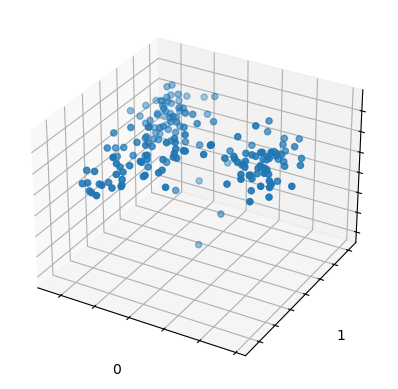

In [5]:
# First we must generate an ordination
from gemelli.rpca import rpca
ordination, distance_mat = rpca(tab.copy())
ordination

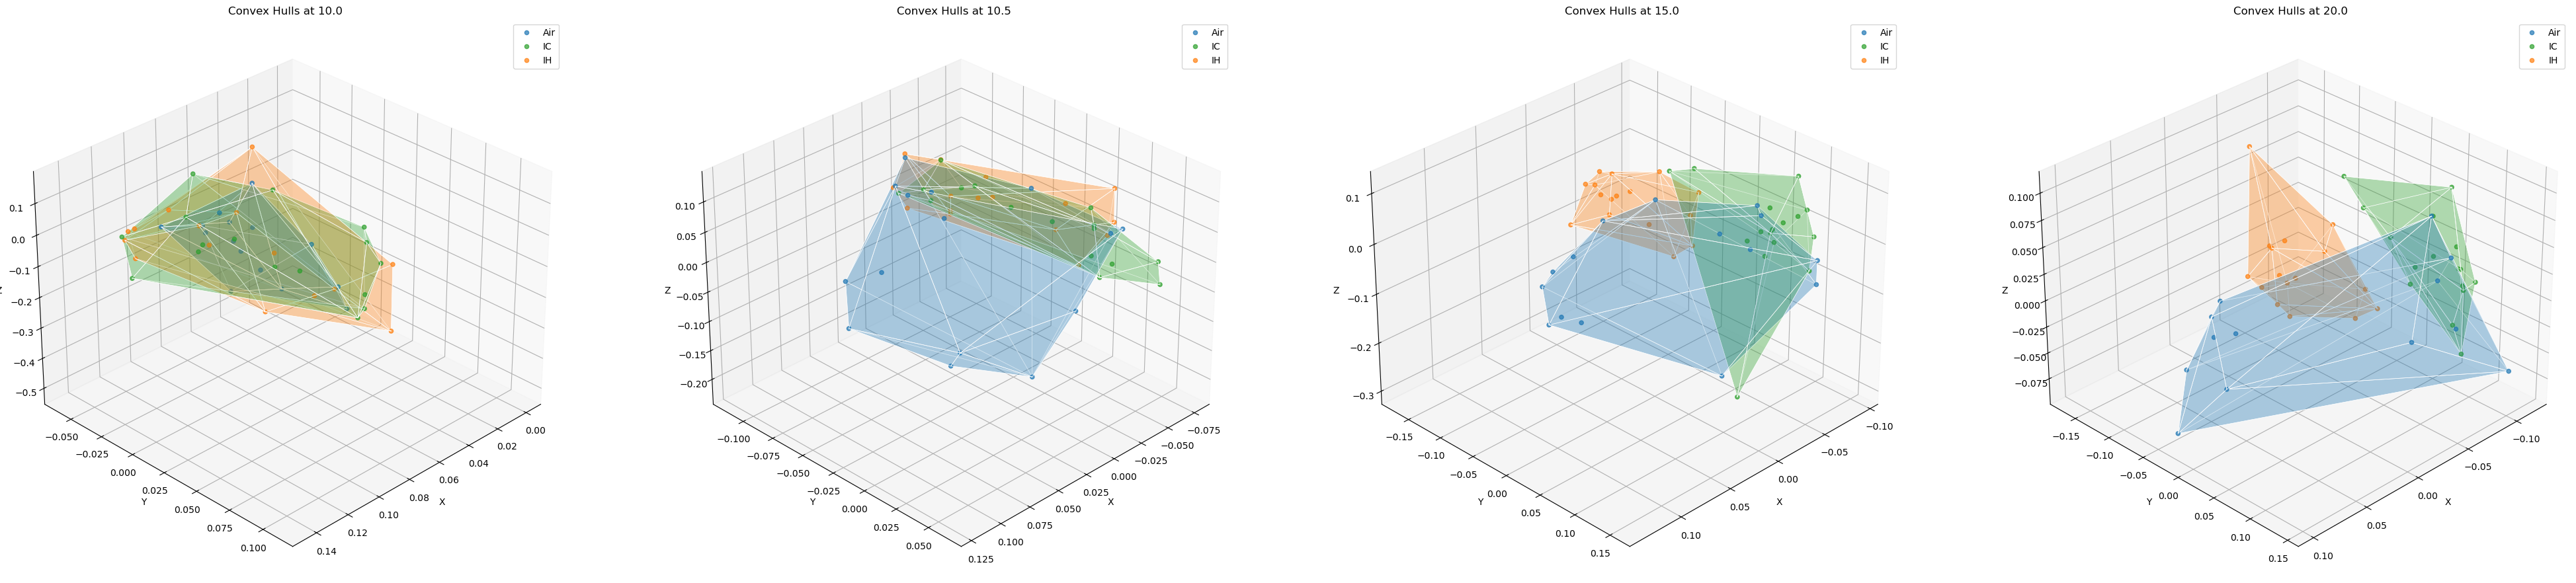

In [6]:
fig, hp = plot_3d_hulls(
    ordination=ordination,
    metadata=metadata,  # necessary
    groupc=groupc,
    subjc=subjc,
    timec=timec, 
    axis=True,
    save=False,
    rotation=60)

### Generate Convex Hull calculations dataframe and subsample by time and group

These plots will calculate the volumes seen above. Visually you should be able to see a trend that resembles the fluctuation in 3d figure sizes. Distributions of points are generated by iterative subsampling. This is done to account for outliers that may be heavily skewing the hull volume.

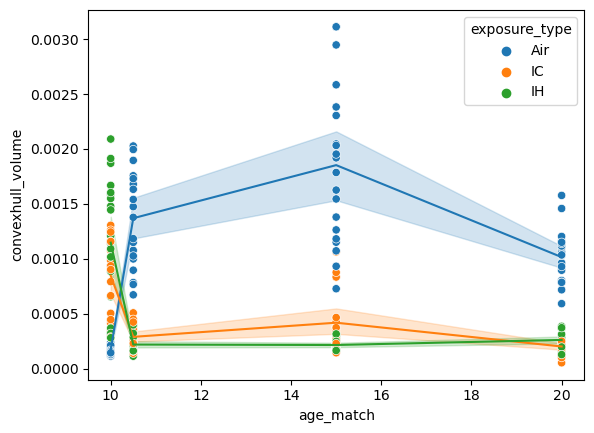

In [7]:
df, ax = plot_group_hulls_over_time(
    ordination, metadata,
    groupc, subjc, timec,
    n_subsamples=10, n_iters=20)

### Box plot of convex hull volumes

These plots show the convex hull volume of individuals over time. In this case, the hulls are calculated over a single subject, not over multiple subjects in one goup.

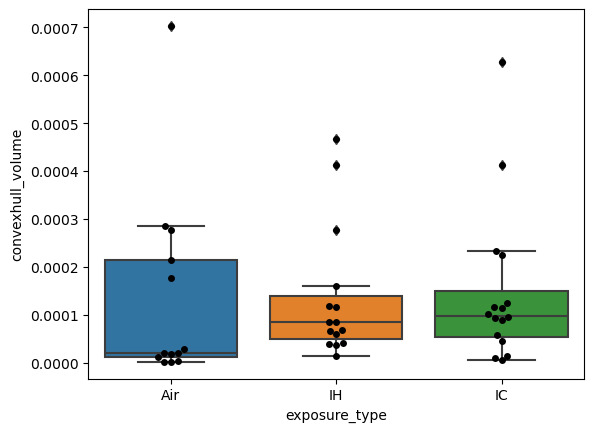

In [8]:
df, ax, hp = plot_indiv_hulls_by_group(
    ordination, metadata,
    groupc, subjc, timec,
    n_subsamples=None, n_iters=20)